# SHUBHAM SHARMA
## IIT BOMBAY
This code is a pytorch implimentation of the U-Net architecture that we have

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Importing the functions for U-net
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

In [3]:
#Checking the number of GPU and then setting the GPU id
print(torch.cuda.current_device())#To know thw current active device
device = torch.device('cuda')
print(device)

0
cuda


In [0]:
num_of_classes=2
input_size=(1, 128, 128, 32)
# input_size[1]*input_size[2]*input_size[3]

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        
        #For first layer input
        self.conv1a=nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv1b=nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN1=nn.BatchNorm3d(32)
        
        #For second layer 
        self.conv2a=nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv2b=nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN2=nn.BatchNorm3d(64)
        
        #For third layer 
        self.conv3a=nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv3b=nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN3=nn.BatchNorm3d(128)
        
        #For forth layer 
        self.conv4a=nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv4b=nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN4=nn.BatchNorm3d(256)
        
        #For fifth/latent layer 
        self.conv5a=nn.Conv3d(in_channels=256, out_channels=512, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv5b=nn.Conv3d(in_channels=512, out_channels=512, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For Upsampling/ sixth layer
        self.upconv1=nn.ConvTranspose3d(in_channels=512, out_channels=256, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv6a=nn.Conv3d(in_channels=512, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv6b=nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For Upsampling/ seventh layer
        self.upconv2=nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv7a=nn.Conv3d(in_channels=256, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv7b=nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For Upsampling/ eighth layer
        self.upconv3=nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv8a=nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv8b=nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)

        #For Upsampling/ ninth layer
        self.upconv4=nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv9a=nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv9b=nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For last layer
        self.convLast=nn.Conv3d(in_channels=32, out_channels=num_of_classes, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For maxpool
        self.max_pool=nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #For activation function
        self.relu = nn.ReLU()
        
    def forward(self,x):
        conv1 = self.conv1a(x)
        conv1 = self.relu(conv1)
        conv1 = self.BN1(conv1)
        conv1 = self.conv1b(conv1)
        conv1 = self.relu(conv1)
        conv1 = self.BN1(conv1)
        pool1 = self.max_pool(conv1)
        ##
        conv2 = self.conv2a(pool1)
        conv2 = self.relu(conv2)
        conv2 = self.BN2(conv2)
        conv2 = self.conv2b(conv2)
        conv2 = self.relu(conv2)
        conv2 = self.BN2(conv2)
        pool2 = self.max_pool(conv2)
        ##
        conv3 = self.conv3a(pool2)
        conv3 = self.relu(conv3)
        conv3 = self.BN3(conv3)
        conv3 = self.conv3b(conv3)
        conv3 = self.relu(conv3)
        conv3 = self.BN3(conv3)
        pool3 = self.max_pool(conv3)
        #
        conv4 = self.conv4a(pool3)
        conv4 = self.relu(conv4)
        conv4 = self.BN4(conv4)
        conv4 = self.conv4b(conv4)
        conv4 = self.relu(conv4)
        conv4 = self.BN4(conv4)
        pool4 = self.max_pool(conv4)
        ##
        conv5 = self.conv5a(pool4)
        conv5 = self.relu(conv5)
        conv5 = self.conv5b(conv5)
        conv5 = self.relu(conv5)
        ##
        up6 = torch.cat((self.upconv1(conv5),conv4),dim=1)
        conv6 = self.conv6a(up6)
        conv6 = self.conv6b(conv6)
        ##
        up7 = torch.cat((self.upconv2(conv6),conv3),dim=1)
        conv7 = self.conv7a(up7)
        conv7 = self.conv7b(conv7)
        ##
        up8 = torch.cat((self.upconv3(conv7),conv2),dim=1)
        conv8 = self.conv8a(up8)
        conv8 = self.conv8b(conv8)
        ##
        up9 = torch.cat((self.upconv4(conv8),conv1),dim=1)
        conv9 = self.conv9a(up9)
        conv9 = self.conv9b(conv9)
        ##
        conv10 = self.convLast(conv9)
#         conv10 = conv10.view(-1,input_size[1]*input_size[2]*input_size[3])
        return conv10
          
          
          
##########################################################################
# model = Net().to(device)#not necessary to add to device
# summary(model, input_size=input_size)        
    
        
        

In [0]:
#Loading the dataset
path2data = 'gdrive/My Drive/Phase 1 Project/type2/Spleen/'
x_train = np.load(path2data + 'x_train_spleen_type2.npy')
y_train = np.load(path2data + 'y_train_spleen_type2.npy')
x_test = np.load(path2data + 'x_test_spleen_type2.npy')
y_test = np.load(path2data + 'y_test_spleen_type2.npy')
y_train_categorical = np.load(path2data + 'y_train_spleen_type2_categorical.npy')
y_test_categorical = np.load(path2data + 'y_test_spleen_type2_categorical.npy')

In [0]:
# converting to tensor

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


In [0]:

trainset = torch.utils.data.TensorDataset(x_train,y_train)# create your datset
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True)

valset = torch.utils.data.TensorDataset(x_test,y_test)# create your datset
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = True)

In [0]:
# learning rate and number of  epoch
lr=1e-7

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()#NO NEED TO BE USING SOFTMAX WHEN USING Crioss Entropy loss
optimizer = optim.Adam(model.parameters(), lr=lr) 

In [0]:
num_of_epochs = 200
#Training the model
total_step = len(trainloader)
for epochs in range(num_of_epochs):
    for i, (images, labels) in enumerate(trainloader):  
            #CHECK THE SHAPE OF BOTH IMAGES AND LABELS
            images = images.to(device)
            images= images.float()
            labels = labels.to(device)  

            #Forward pass
            outputs = model(images)
            labels = labels.long()
            loss = loss_fn(outputs, labels)

            # Backpropagation and then optimization
            optimizer.zero_grad()#Initially setting the gradient values to zero so backward() can find the gradient
            loss.backward()#backpropagate and then optimize
            optimizer.step()
        #     if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epochs+1, num_of_epochs, i+1, total_step, loss.item()))
    torch.save(model, path2data + 'spleen_type2CE')

    
    
    

In [0]:
def show_slices(slices):
# Function to display row of image slices
      fig, axes = plt.subplots(1, len(slices))
      for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
saved = torch.load(path2data + 'spleen_type2CE')

Text(0.5, 0.98, 'Center slices for original output')

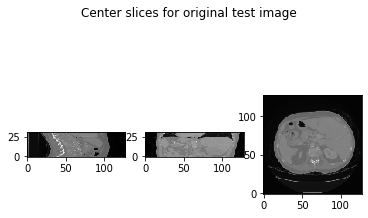

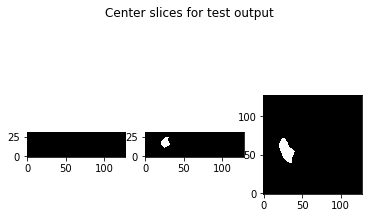

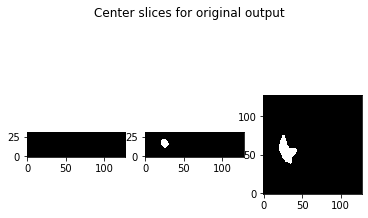

In [0]:
#Checking for train image
i=2
im = x_train[i].reshape(1,x_train[i].shape[0],x_train[i].shape[1],x_train[i].shape[2],x_train[i].shape[3])
n_im = x_train[i][0,:,:,:]
n_im = n_im.cpu()
n_im = n_im.detach().numpy()
slice_0 = n_im[64, :, :]
slice_1 = n_im[:, 64, :]
slice_2 = n_im[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original test image") 

# im = torch.from_numpy(im)
im = im.to(device)
im = im.float()
output = saved(im)
pred = F.softmax(output,1)
pred = pred[0,:,:,:]
pred = pred.cpu()
pred = pred.detach().numpy()
# print(pred.shape)
result = np.argmax(pred, axis = 0)
result = result.reshape(128, 128, 32)
slice_0 = result[64, :, :]
slice_1 = result[:, 64, :]
slice_2 = result[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for test output")

ori = y_train[i]
ori = ori.cpu()
ori = ori.detach().numpy()
slice_0 = ori[64, :, :]
slice_1 = ori[:, 64, :]
slice_2 = ori[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original output")

Text(0.5, 0.98, 'Center slices for original output')

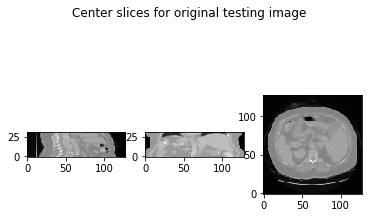

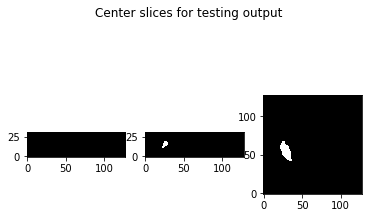

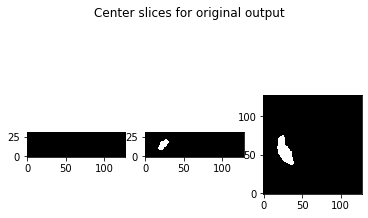

In [0]:
#Checking for test image
i=5
im = x_test[i].reshape(1,x_test[i].shape[0],x_test[i].shape[1],x_test[i].shape[2],x_test[i].shape[3])
n_im = x_test[i][0,:,:,:]
n_im = n_im.cpu()
n_im = n_im.detach().numpy()
slice_0 = n_im[64, :, :]
slice_1 = n_im[:, 64, :]
slice_2 = n_im[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original test image") 

# im = torch.from_numpy(im)
im = im.to(device)
im = im.float()
output = saved(im)
pred = F.softmax(output,1)
pred = pred[0,:,:,:]
pred = pred.cpu()
pred = pred.detach().numpy()
# print(pred.shape)
result = np.argmax(pred, axis = 0)
result = result.reshape(128, 128, 32)
slice_0 = result[64, :, :]
slice_1 = result[:, 64, :]
slice_2 = result[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for test output")

ori = y_test[i]
ori = ori.cpu()
ori = ori.detach().numpy()
slice_0 = ori[64, :, :]
slice_1 = ori[:, 64, :]
slice_2 = ori[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original output")

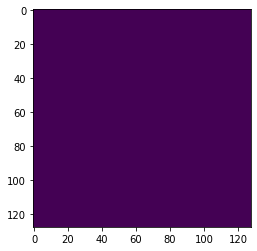

In [0]:
plt.imshow(ori[:,:,16].astype('float32'))

2792

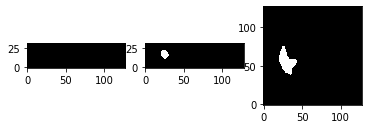

In [0]:
z = Y[1]
z.shape
slice_0 = z[64, :, :]
slice_1 = z[:, 64, :]
slice_2 = z[:, :, 16]
show_slices([slice_0, slice_1, slice_2])

In [0]:
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.autograd import Variable
from torch.nn import MSELoss, SmoothL1Loss, L1Loss


def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    target = target.float()
    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)


class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index,
                                                    weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)


class GeneralizedDiceLoss(nn.Module):
    """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True):
        super(GeneralizedDiceLoss, self).__init__()
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        assert input.size() == target.size(), "'input' and 'target' must have the same shape"

        # mask ignore_index if present
        if self.ignore_index is not None:
            mask = target.clone().ne_(self.ignore_index)
            mask.requires_grad = False

            input = input * mask
            target = target * mask

        input = flatten(input)
        target = flatten(target)

        target = target.float()
        target_sum = target.sum(-1)
        class_weights = Variable(1. / (target_sum * target_sum).clamp(min=self.epsilon), requires_grad=False)

        intersect = (input * target).sum(-1) * class_weights
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
            intersect = weight * intersect
        intersect = intersect.sum()

        denominator = ((input + target).sum(-1) * class_weights).sum()

        return 1. - 2. * intersect / denominator.clamp(min=self.epsilon)


class WeightedCrossEntropyLoss(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, weight=None, ignore_index=-1):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

    def forward(self, input, target):
        class_weights = self._class_weights(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
            class_weights = class_weights * weight
        return F.cross_entropy(input, target, weight=class_weights, ignore_index=self.ignore_index)

    @staticmethod
    def _class_weights(input):
        # normalize the input first
        input = F.softmax(input, _stacklevel=5)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = Variable(nominator / denominator, requires_grad=False)
        return class_weights


class BCELossWrapper:
    """
    Wrapper around BCE loss functions allowing to pass 'ignore_index' as well as 'skip_last_target' option.
    """

    def __init__(self, loss_criterion, ignore_index=-1, skip_last_target=False):
        if hasattr(loss_criterion, 'ignore_index'):
            raise RuntimeError(f"Cannot wrap {type(loss_criterion)}. Use 'ignore_index' attribute instead")
        self.loss_criterion = loss_criterion
        self.ignore_index = ignore_index
        self.skip_last_target = skip_last_target

    def __call__(self, input, target):
        if self.skip_last_target:
            target = target[:, :-1, ...]

        assert input.size() == target.size()

        masked_input = input
        masked_target = target
        if self.ignore_index is not None:
            mask = target.clone().ne_(self.ignore_index)
            mask.requires_grad = False

            masked_input = input * mask
            masked_target = target * mask

        return self.loss_criterion(masked_input, masked_target)


class PixelWiseCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights=None, ignore_index=None):
        super(PixelWiseCrossEntropyLoss, self).__init__()
        self.register_buffer('class_weights', class_weights)
        self.ignore_index = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, target, weights):
        assert target.size() == weights.size()
        # normalize the input
        log_probabilities = self.log_softmax(input)
        # standard CrossEntropyLoss requires the target to be (NxDxHxW), so we need to expand it to (NxCxDxHxW)
        target = expand_as_one_hot(target, C=input.size()[1], ignore_index=self.ignore_index)
        # expand weights
        weights = weights.unsqueeze(0)
        weights = weights.expand_as(input)

        # mask ignore_index if present
        if self.ignore_index is not None:
            mask = Variable(target.data.ne(self.ignore_index).float(), requires_grad=False)
            log_probabilities = log_probabilities * mask
            target = target * mask

        # create default class_weights if None
        if self.class_weights is None:
            class_weights = torch.ones(input.size()[1]).float().to(input.device)
            self.register_buffer('class_weights', class_weights)

        # resize class_weights to be broadcastable into the weights
        class_weights = self.class_weights.view(1, -1, 1, 1, 1)

        # multiply weights tensor by class weights
        weights = class_weights * weights

        # compute the losses
        result = -weights * target * log_probabilities
        # average the losses
        return result.mean()


class MSEWithLogitsLoss(MSELoss):
    """
    This loss combines a `Sigmoid` layer and the `MSELoss` in one single class.
    """

    def __init__(self):
        super(MSEWithLogitsLoss, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, target):
        return super().forward(self.sigmoid(input), target)


class TagsAngularLoss(nn.Module):
    def __init__(self, tags_coefficients):
        super(TagsAngularLoss, self).__init__()
        self.tags_coefficients = tags_coefficients

    def forward(self, inputs, targets, weight):
        assert isinstance(inputs, list)
        # if there is just one output head the 'inputs' is going to be a singleton list [tensor]
        # and 'targets' is just going to be a tensor (that's how the HDF5Dataloader works)
        # so wrap targets in a list in this case
        if len(inputs) == 1:
            targets = [targets]
        assert len(inputs) == len(targets) == len(self.tags_coefficients)
        loss = 0
        for input, target, alpha in zip(inputs, targets, self.tags_coefficients):
            loss += alpha * square_angular_loss(input, target, weight)

        return loss


def square_angular_loss(input, target, weights=None):
    """
    Computes square angular loss between input and target directions.
    Makes sure that the input and target directions are normalized so that torch.acos would not produce NaNs.
    :param input: 5D input tensor (NCDHW)
    :param target: 5D target tensor (NCDHW)
    :param weights: 3D weight tensor in order to balance different instance sizes
    :return: per pixel weighted sum of squared angular losses
    """
    assert input.size() == target.size()
    # normalize and multiply by the stability_coeff in order to prevent NaN results from torch.acos
    stability_coeff = 0.999999
    input = input / torch.norm(input, p=2, dim=1).detach().clamp(min=1e-8) * stability_coeff
    target = target / torch.norm(target, p=2, dim=1).detach().clamp(min=1e-8) * stability_coeff
    # compute cosine map
    cosines = (input * target).sum(dim=1)
    error_radians = torch.acos(cosines)
    if weights is not None:
        return (error_radians * error_radians * weights).sum()
    else:
        return (error_radians * error_radians).sum()


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)


def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    assert input.dim() == 4

    shape = input.size()
    shape = list(shape)
    shape.insert(1, C)
    shape = tuple(shape)

    # expand the input tensor to Nx1xDxHxW
    src = input.unsqueeze(0)

    if ignore_index is not None:
        # create ignore_index mask for the result
        expanded_src = src.expand(shape)
        mask = expanded_src == ignore_index
        # clone the src tensor and zero out ignore_index in the input
        src = src.clone()
        src[src == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, src, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, src, 1)


SUPPORTED_LOSSES = ['BCEWithLogitsLoss', 'CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'PixelWiseCrossEntropyLoss',
                    'GeneralizedDiceLoss', 'DiceLoss', 'TagsAngularLoss', 'MSEWithLogitsLoss', 'MSELoss',
                    'SmoothL1Loss', 'L1Loss']


def get_loss_criterion(config):
    """
    Returns the loss function based on provided configuration
    :param config: (dict) a top level configuration object containing the 'loss' key
    :return: an instance of the loss function
    """
    assert 'loss' in config, 'Could not find loss function configuration'
    loss_config = config['loss']
    name = loss_config['name']

    ignore_index = loss_config.get('ignore_index', None)
    weight = loss_config.get('weight', None)

    if weight is not None:
        # convert to cuda tensor if necessary
        weight = torch.tensor(weight).to(config['device'])

    if name == 'BCEWithLogitsLoss':
        skip_last_target = loss_config.get('skip_last_target', False)
        if ignore_index is None and not skip_last_target:
            return nn.BCEWithLogitsLoss()
        else:
            return BCELossWrapper(nn.BCEWithLogitsLoss(), ignore_index=ignore_index, skip_last_target=skip_last_target)
    elif name == 'CrossEntropyLoss':
        if ignore_index is None:
            ignore_index = -100  # use the default 'ignore_index' as defined in the CrossEntropyLoss
        return nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'WeightedCrossEntropyLoss':
        if ignore_index is None:
            ignore_index = -100  # use the default 'ignore_index' as defined in the CrossEntropyLoss
        return WeightedCrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'PixelWiseCrossEntropyLoss':
        return PixelWiseCrossEntropyLoss(class_weights=weight, ignore_index=ignore_index)
    elif name == 'GeneralizedDiceLoss':
        return GeneralizedDiceLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'DiceLoss':
        sigmoid_normalization = loss_config.get('sigmoid_normalization', True)
        skip_last_target = loss_config.get('skip_last_target', False)
        return DiceLoss(weight=weight, ignore_index=ignore_index, sigmoid_normalization=sigmoid_normalization,
                        skip_last_target=skip_last_target)
    elif name == 'TagsAngularLoss':
        tags_coefficients = loss_config['tags_coefficients']
        return TagsAngularLoss(tags_coefficients)
    elif name == 'MSEWithLogitsLoss':
        return MSEWithLogitsLoss()
    elif name == 'MSELoss':
        return MSELoss()
    elif name == 'SmoothL1Loss':
        return SmoothL1Loss()
    elif name == 'L1Loss':
        return L1Loss()
    else:
        raise RuntimeError(f"Unsupported loss function: '{name}'. Supported losses: {SUPPORTED_LOSSES}")

In [0]:
# converting to tensor

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train_categorical = torch.from_numpy(y_train_categorical)
y_test_categorical = torch.from_numpy(y_test_categorical)


In [0]:

trainset = torch.utils.data.TensorDataset(x_train,y_train_categorical)# create your datset
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1, shuffle = True)

valset = torch.utils.data.TensorDataset(x_test,y_test_categorical)# create your datset
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = True)

In [10]:
# Let us find the dice score for both CE and dice loss
loss_fn = DiceLoss(sigmoid_normalization=False)

#Case 1 when dice loss is used
spleen_ce = torch.load(path2data + 'spleen_type2CE')
dice_validation = []
for i, (images, labels) in enumerate(valloader):  
    #CHECK THE SHAPE OF BOTH IMAGES AND LABELS
    images = images.to(device)
    images= images.float()
    labels = labels.to(device)  

    #Forward pass
    outputs = spleen_ce(images)
    loss = loss_fn(outputs, labels)
    print(loss.item())
    dice_validation.append(loss.item())

0.09244218468666077
0.21134865283966064
0.2837376296520233
0.1577034890651703
0.15436267852783203
0.16510549187660217
0.27240288257598877
0.18695518374443054
0.13028055429458618


In [11]:
print(dice_validation)
print(np.mean(dice_validation))
print(1 - np.mean(dice_validation))

[0.09244218468666077, 0.21134865283966064, 0.2837376296520233, 0.1577034890651703, 0.15436267852783203, 0.16510549187660217, 0.27240288257598877, 0.18695518374443054, 0.13028055429458618]
0.18381541636255053
0.8161845836374495


In [12]:
dice_training = []
for i, (images, labels) in enumerate(trainloader):  
    #CHECK THE SHAPE OF BOTH IMAGES AND LABELS
    images = images.to(device)
    images= images.float()
    labels = labels.to(device)  

    #Forward pass
    outputs = spleen_ce(images)
    loss = loss_fn(outputs, labels)
    print(loss.item())
    dice_training.append(loss.item())


0.26424893736839294
0.0954914391040802
0.10464537143707275
0.18128076195716858
0.12713661789894104
0.1331011950969696
0.17414793372154236
0.14872482419013977
0.16690367460250854
0.10571318864822388
0.0820525586605072
0.12045857310295105
0.12203001976013184
0.23348495364189148
0.11516210436820984
0.10943853855133057
0.10083422064781189
0.12978065013885498
0.07994824647903442
0.16820603609085083
0.15266460180282593
0.11720937490463257
0.13476377725601196
0.11289745569229126
0.15036392211914062
0.09366032481193542
0.12749481201171875
0.19140714406967163
0.1454552710056305
0.10493451356887817
0.1355251967906952
0.14113402366638184


In [13]:
print(dice_training)
print(np.mean(dice_training))
print(1 - np.mean(dice_training))

[0.26424893736839294, 0.0954914391040802, 0.10464537143707275, 0.18128076195716858, 0.12713661789894104, 0.1331011950969696, 0.17414793372154236, 0.14872482419013977, 0.16690367460250854, 0.10571318864822388, 0.0820525586605072, 0.12045857310295105, 0.12203001976013184, 0.23348495364189148, 0.11516210436820984, 0.10943853855133057, 0.10083422064781189, 0.12978065013885498, 0.07994824647903442, 0.16820603609085083, 0.15266460180282593, 0.11720937490463257, 0.13476377725601196, 0.11289745569229126, 0.15036392211914062, 0.09366032481193542, 0.12749481201171875, 0.19140714406967163, 0.1454552710056305, 0.10493451356887817, 0.1355251967906952, 0.14113402366638184]
0.13657188322395086
0.8634281167760491
